BlazePose is a novel convolutional neural network architecture for human pose estimation that can run in real-time on mobile devices. It can detect 33 body keypoints, including face, hands, and feet, which are useful for applications like fitness, dance, and gesture control. BlazePose is based on a two-step detector-tracker pipeline that first locates the pose region-of-interest and then predicts the keypoints from it. BlazePose outperforms existing pose models in terms of accuracy, speed, and memory. BlazePose can also provide clinically viable body keypoints for virtual motion assessment.


[
https://arxiv.org/abs/2006.10204
](https://)



#Installations and dependensies

In [5]:
#@title Mediapipe instalation
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


## Download tools from github:

In [6]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-06 16:51:31--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0s      

2025-12-06 16:51:31 (59,6 MB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-06 16:51:32--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443… connecté.
requête HTTP transmise, en attente de la réponse

## Imports

In [7]:
# from tools import video,utils,visualize
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [8]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import random



2025-12-06 16:51:34.549867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 16:51:34.560223: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 16:51:34.647528: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 16:51:34.720347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765007494.809026   14880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765007494.83

## Functions

In [9]:
def video_pose_estimation(video_path: str,
                          output_path: str = None,
                          save_video: bool = False,
                          verbose: bool = True):
    """
    Applique BlazePose à une vidéo.

    Args:
        video_path: chemin de la vidéo d'entrée.
        output_path: chemin de la vidéo de sortie (si save_video=True).
        save_video: si True, écrit une vidéo annotée.
        verbose: affichage des infos.

    Returns:
        vid_out (Video ou None),
        marker_df,
        visibility_df
    """
    output = []
    timestamps = []

    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)

    # Reader
    vid_cap = cv2.VideoCapture(vid.path)

    # Writer optionnel
    video_writer = None
    if save_video:
        if output_path is None:
            base, ext = os.path.splitext(video_path)
            output_path = base + "_pose.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_path, fourcc, vid.fps, (vid.width, vid.height))

    if verbose:
        print(f"Processing- Name- {video_name}:")
        print(f" Width- {vid.width}, Height- {vid.height} ")
        print(f" number of frames- {vid.nFrames}, Fps- {vid.fps} ")
        print(f" Path-{video_path} \n")

    # BlazePose
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for frame_index in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            # BGR -> RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # timestamp
            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            # Inference
            results = pose.process(img_rgb)
            output.append(results)

            # Dessin + écriture vidéo seulement si demandé
            if save_video and video_writer is not None:
                img_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                mp.solutions.drawing_utils.draw_landmarks(
                    img_out,
                    results.pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style()
                )
                video_writer.write(img_out)

    # Fermer ressources
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

    # Landmarks -> tables
    try:
        marker_df, visibility_df = landmarks_2_table(
            output,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table a échoué:", repr(e))
        marker_df, visibility_df = output, []
        print("please replace the video")

    vid_out = Video.from_path(output_path) if (save_video and output_path is not None) else None
    return vid_out, marker_df, visibility_df


# BlazePose Mediapipe - Extract Pose Estimation From Video:

## Upload your video

In [10]:
#from google.colab import files
# uploaded = files.upload()
# for file_name in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=file_name, length=len(uploaded[file_name])))


In [29]:
# uploads DESRes videos by label
def get_DESRes_videos_by_label(label, n, root="GESRes_filtered_gestures"):
    """
    Retourne n vidéos aléatoires correspondant au label demandé.
    
    - Si n <= nb vidéos disponibles → renvoie n vidéos
    - Si n > nb vidéos disponibles → renvoie toutes les vidéos disponibles et prévient l'utilisateur
    - Si le label n'existe pas → erreur claire
    - Si aucune vidéo pour ce label → erreur claire
    """

    label_path = os.path.join(root, label)

    # 1. Vérifier que le label existe physiquement
    if not os.path.isdir(label_path):
        raise ValueError(
            f"❌ Label '{label}' introuvable.\n"
            f"Labels disponibles : {os.listdir(root)}"
        )

    # 2. Lister les vidéos dans ce dossier
    videos = [f for f in os.listdir(label_path) if f.endswith(".mp4")]

    if len(videos) == 0:
        raise ValueError(f"❌ Aucune vidéo trouvée pour le label '{label}'.")

    available = len(videos)

    # 3. Si la demande dépasse ce qui existe → renvoyer tout
    if n > available:
        print(
            f"⚠️ Seulement {available} vidéos disponibles pour '{label}', "
            f"mais {n} demandées.\n"
            f"👉 Retour de TOUTES les vidéos disponibles."
        )
        selected = videos  # toutes les vidéos
    else:
        selected = random.sample(videos, n)

    # 4. Retourner chemins absolus
    return [os.path.join(label_path, v) for v in selected]

import os
import random

# Return n random videos from a given label in the Jester dataset
def get_jester_videos_by_label(label, n, root="Jester_filtered_gestures"):
    """
    Retourne 'n' vidéos choisies aléatoirement parmi celles du label donné.
    
    - label : nom du label (ex : "Stop Sign")
    - n     : nombre de vidéos à retourner
    - root  : dossier contenant les sous-dossiers par label
    """

    # Chemin vers le dossier du label
    label_folder = os.path.join(root, label)

    # Vérification du label
    if not os.path.isdir(label_folder):
        raise ValueError(f"❌ Label '{label}' non trouvé dans {root}")

    # Liste des vidéos dans ce label
    videos = [os.path.join(label_folder, f) 
              for f in os.listdir(label_folder)
              if f.endswith(".mp4")]

    if len(videos) == 0:
        raise ValueError(f"❌ Aucun fichier vidéo .mp4 trouvé pour le label '{label}'")

    # Vérifier qu'on peut en prélever N
    if n > len(videos):
        raise ValueError(f"❌ Demande {n} vidéos mais seulement {len(videos)} disponibles pour '{label}'")

    # Sélection aléatoire
    selected = random.sample(videos, n)

    return selected



Labels disponibles : ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

In [12]:
#use case
videos = get_DESRes_videos_by_label("point", 10)
videos


['GESRes_filtered_gestures/point/859_Politician3_point_moving.mp4',
 'GESRes_filtered_gestures/point/2276_Lecturer3_point_down.mp4',
 'GESRes_filtered_gestures/point/1666_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/838_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/1171_Clinician1_point_forward.mp4',
 'GESRes_filtered_gestures/point/1664_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/942_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/1679_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/1665_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/834_Politician3_point_to_side.mp4']

Labels disponibles : ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']


In [30]:
videos = get_jester_videos_by_label("Stop Sign", 5)
videos

['Jester_filtered_gestures/Stop Sign/95238.mp4',
 'Jester_filtered_gestures/Stop Sign/577.mp4',
 'Jester_filtered_gestures/Stop Sign/131450.mp4',
 'Jester_filtered_gestures/Stop Sign/39055.mp4',
 'Jester_filtered_gestures/Stop Sign/107033.mp4']

## Estimate pose

In [13]:
# output_path = "proc.mp4"
# vid, marker_df,visibility_df  = video_pose_estimation(video_path = file_name,output_path =output_path)

## Veiw your results
Notice- Convert function is only used for presenting Video in google Colab

In [14]:
# vid.convert()
# vid.play(frac = 0.75) #change frac acording to the video width and height

# Normalization

In [ ]:
KEYPOINTS = [0, 2, 5, 7, 8, 9, 10, 11, 12] + list(range(13, 23))  # 16 joints (visage + haut du corps)
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)


def marker_to_traj_vec(marker_df,
                       visibility_df,
                       keypoints=KEYPOINTS,
                       target_len: int = 50,
                       vis_thresh: float = VIS_THRESH) -> np.ndarray:
    """
    Transforme marker_df (T_raw, 100) + visibility_df en une trajectoire
    normalisée et vectorisée pour DMP.

    Accepte indifféremment:
      - marker_df : np.ndarray ou pandas.DataFrame
      - visibility_df : np.ndarray ou pandas.DataFrame

    Retourne:
        traj_vec : (T, 2 * len(keypoints))  -> typiquement (50, 32)
        (coords = (y,z) normalisés par les épaules, resamplés en target_len)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupérer le temps --------
    t_src = marker_df[:, 0]  # (T_raw,)

    # -------- 2) Extraire (y, z) pour les keypoints choisis --------
    # marker_df: [time, x0,y0,z0, x1,y1,z1, ...]
    seq_yz = np.zeros((T_raw, n_kp, 2), dtype=float)  # (T_raw, 16, 2)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp  # x = base, y = base+1, z = base+2
        y_col = base + 1
        z_col = base + 2
        seq_yz[:, i, 0] = marker_df[:, y_col]
        seq_yz[:, i, 1] = marker_df[:, z_col]

    # -------- 3) Appliquer le masque de visibilité --------
    # visibility_df: [time, vis_0, vis_1, ..., vis_32]
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_col = 1 + kp
        vis_sel[:, i] = visibility_df[:, vis_col]

    # Mettre les points peu visibles à NaN
    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_yz[mask_invis, :] = np.nan

    # -------- 4) Remplir les NaN par interpolation temporelle --------
    # On interpole chaque dimension (joint, coord) indépendamment
    seq_flat = seq_yz.reshape(T_raw, -1)  # (T_raw, n_kp*2)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            # interpolation sur les indices de temps (ou t_src si tu préfères)
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            # si quasi rien de valide : on met à 0
            seq_flat[:, d] = 0.0

    seq_yz_filled = seq_flat.reshape(T_raw, n_kp, 2)  # (T_raw, 16, 2)

    # -------- 5) Normalisation par les épaules (centrage + scale) --------
    # On suppose que 11 et 12 sont dans keypoints
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("Les keypoints 11 et 12 (épaules) doivent être dans KEYPOINTS.")

    shoulder_L = seq_yz_filled[:, idx_sh_l, :]  # (T_raw, 2)
    shoulder_R = seq_yz_filled[:, idx_sh_r, :]  # (T_raw, 2)

    centers = 0.5 * (shoulder_L + shoulder_R)  # (T_raw, 2)
    seq_centered = seq_yz_filled - centers[:, None, :]  # (T_raw, 16, 2)

    # Distance épaule-épaule pour chaque frame
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)  # (T_raw,)
    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    if finite_sd.size == 0:
        scale = 1.0
    else:
        scale = np.mean(finite_sd)

    seq_norm = seq_centered / scale  # (T_raw, 16, 2)

    # -------- 6) Normalisation temporelle à target_len frames --------
    if target_len is not None and target_len > 0:
        # On interpole dans le temps réel t_src
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)  # (T_raw, 32)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]), dtype=float)

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(
                t_new, t_src, seq_norm_flat[:, d]
            )

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 2)  # (target_len, 16, 2)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP : (T_out, 2 * n_kp) --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 2)  # (T_out, 32)

    return traj_vec


# DMP


In [16]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        """
        Y : (T, D) trajectoire vectorielle (ici D=32)
        """
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


In [17]:
# dmp_vec = DMPVector(n_basis=20)
# traj_vec = marker_to_traj_vec(marker_df,visibility_df)
# T = 50
# dmp_vec.fit(traj_vec) # fit une trajectoire vectorielle -c'est l'extraction puis normalisation des points de la video du dataset

# gen_traj_vec = dmp_vec.rollout(T=T, amplitude_scale=1.0)  # (T, 32)
# print(gen_traj_vec.shape)


# Dataset usage



In [32]:
#Given a label and a number of video, extract marker_df and visibility_df 
#Then, normalize and resample them to build a dataset for DMP training
#output : X (N, T, 32) and video_paths (list of N strings): array of shape (N, T, 32) where N is number of videos

labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']
labels_jester = ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']

def build_gesture_dataset(label, n, target_len=50):
    
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")
    
    X = []

    for vp in video_paths:
        try:
            # On ne sauvegarde pas de vidéo ici -> save_video=False
            vid_out, marker_df, visibility_df = video_pose_estimation(
                vp, save_video=False, verbose=False
            )

            traj = marker_to_traj_vec(marker_df, visibility_df, target_len=target_len)
            X.append(traj)   # (T, 32)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X) == 0:
        raise RuntimeError(
            f"❌ Aucune trajectoire n'a pu être extraite pour le label '{label}'."
        )

    X = np.stack(X, axis=0)  # (N, T, 32)
    return X, video_paths


In [19]:
X_point, vids_point = build_gesture_dataset("point", 10, target_len=50)
X_point.shape


I0000 00:00:1765007497.244797   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007497.247269   15130 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765007497.295234   15113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007497.320272   15103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007497.336234   15105 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
100%|██████████| 61/61 [00:01<00:00, 45.65it/s]
I0000 00:00:1765

(10, 50, 32)

# Execution example :
Renvoie Y obtenu avec les 10 démo du label "point"

In [20]:
dmp_point = DMPVector(n_basis=20)
dmp_point.fit_multi(X_point)          # on utilise T et D depuis X_point

Y_gen = dmp_point.rollout(T=50)       # (50, 32)
print(Y_gen.shape)


(50, 32)


# Generalization 
Let's create the dictionnary for each label

In [ ]:
gesture_dmps = {}

for lab in labels_DESRes:
    X_lab, vids_lab = build_gesture_dataset(lab, n=200, target_len=50)
    dmp = DMPVector(n_basis=20)
    dmp.fit_multi(X_lab)
    gesture_dmps[lab] = dmp


I0000 00:00:1765007511.106297   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007511.107568   15708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/313 [00:00<?, ?it/s]

W0000 00:00:1765007511.182525   15700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007511.206479   15702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 313/313 [00:06<00:00, 45.10it/s]
I0000 00:00:1765007518.081317   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007518.082348   15759 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 1 vidéos disponibles pour 'finger', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/88 [00:00<?, ?it/s]W0000 00:00:1765007518.128563   15745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007518.151273   15752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 88/88 [00:01<00:00, 44.28it/s]
I0000 00:00:1765007520.109226   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007520.110396   15810 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 8 vidéos disponibles pour 'cup', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/33 [00:00<?, ?it/s]W0000 00:00:1765007520.158141   15793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007520.183491   15803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 33/33 [00:00<00:00, 41.53it/s]
I0000 00:00:1765007520.938295   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007520.940142   15861 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765007520.991551   15846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007521.015769   15852 inference_feedback_ma

⚠️ Seulement 1 vidéos disponibles pour 'knock', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765007526.839726   16219 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765007526.908805   16203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007526.936827   16214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 52/52 [00:01<00:00, 42.19it/s]


⚠️ Seulement 5 vidéos disponibles pour 'clasp', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765007528.097932   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007528.098831   16270 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765007528.142479   16253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007528.167740   16258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 42.55it/s]
I0000 00:00:1765007528.830445   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007528.831831   16323 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ Seulement 171 vidéos disponibles pour 'hold', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765007532.713727   16531 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1765007532.767715   16513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007532.792784   16522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 31/31 [00:00<00:00, 39.94it/s]
I0000 00:00:1765007533.512290   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/177 [00:00<?, ?it/s]I0000 00:00:1765007533.513284   16582 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765007533.562478   16567 inference_feedback_manager.cc:114] Feedb

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2157_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765007700.230390   21519 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/47 [00:00<?, ?it/s]W0000 00:00:1765007700.290404   21509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007700.317063   21514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 47/47 [00:01<00:00, 46.71it/s]
I0000 00:00:1765007701.267602   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/139 [00:00<?, ?it/s]I0000 00:00:1765007701.268765   21570 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765007701.317755   21552 inference_feedback_manager.cc:114] Feedb

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/122 [00:00<?, ?it/s]W0000 00:00:1765007720.637867   22117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007720.663585   22127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 122/122 [00:02<00:00, 47.73it/s]
I0000 00:00:1765007723.173279   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007723.174252   22187 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/36 [00:00<?, ?it/s]W0000 00:00:1765007723.219589   22172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007723.245698   22179 inference_feedback

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2243_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765007779.785987   23848 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/27 [00:00<?, ?it/s]W0000 00:00:1765007779.827185   23830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007779.852121   23841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 27/27 [00:00<00:00, 43.67it/s]
I0000 00:00:1765007780.432912   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007780.434004   23899 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765007780.485045   23888 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2177_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/85 [00:00<?, ?it/s]W0000 00:00:1765007792.734226   24228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007792.763701   24237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 85/85 [00:01<00:00, 45.58it/s]
I0000 00:00:1765007794.568365   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007794.569398   24300 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/80 [00:00<?, ?it/s]W0000 00:00:1765007794.618958   24284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007794.644851   24292 inference_feedback_ma

⚠️ Seulement 1 vidéos disponibles pour 'punch', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765007847.219815   25996 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/19 [00:00<?, ?it/s]W0000 00:00:1765007847.302375   25985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007847.329352   25978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 19/19 [00:00<00:00, 36.13it/s]
I0000 00:00:1765007847.770425   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007847.771694   26047 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 18 vidéos disponibles pour 'point', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765007847.820642   26032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007847.847588   26040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 40.04it/s]
I0000 00:00:1765007848.843030   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007848.844291   26098 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765007848.897893   26080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007848.920017   26089 inference_feedback_ma

⚠️ Seulement 1 vidéos disponibles pour 'wave', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765007871.852626   26984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007871.880405   26994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 43/43 [00:01<00:00, 42.11it/s]
I0000 00:00:1765007872.823338   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007872.824347   27052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 90 vidéos disponibles pour 'show', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/77 [00:00<?, ?it/s]W0000 00:00:1765007872.866085   27034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007872.894449   27043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 77/77 [00:01<00:00, 47.11it/s]
I0000 00:00:1765007874.479144   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007874.479896   27103 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765007874.524292   27088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007874.550101   27089 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1805_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765007947.495049   29710 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765007947.548248   29694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007947.576406   29700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:00<00:00, 46.04it/s]
I0000 00:00:1765007948.447398   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007948.448804   29762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]W0000 00:00:1765007948.505677   29746 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1923_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/54 [00:00<?, ?it/s]W0000 00:00:1765007983.517595   30618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007983.552246   30627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 54/54 [00:01<00:00, 42.44it/s]
I0000 00:00:1765007984.773229   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765007984.774845   30685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/154 [00:00<?, ?it/s]W0000 00:00:1765007984.827605   30667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765007984.849483   30676 inference_feedback_m

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/2231_Lecturer3_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765008000.243453   30927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008000.271536   30931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 40.57it/s]
I0000 00:00:1765008000.972605   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008000.973973   30992 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/73 [00:00<?, ?it/s]W0000 00:00:1765008001.018175   30974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008001.040899   30983 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1925_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008011.799369   31405 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/23 [00:00<?, ?it/s]W0000 00:00:1765008011.851192   31387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008011.879345   31394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 23/23 [00:00<00:00, 36.73it/s]
I0000 00:00:1765008012.460621   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008012.461938   31456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/56 [00:00<?, ?it/s]W0000 00:00:1765008012.511554   31449 inference_feedback_manager.cc:114] Feedba

⚠️ Seulement 3 vidéos disponibles pour 'soft', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765008022.979941   31753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008023.018970   31758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 32/32 [00:00<00:00, 38.59it/s]
I0000 00:00:1765008023.795658   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008023.796861   31814 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/25 [00:00<?, ?it/s]W0000 00:00:1765008023.855646   31799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008023.878033   31807 inference_feedback_ma

⚠️ Seulement 9 vidéos disponibles pour 'present', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765008025.123394   31900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008025.150870   31908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 42.76it/s]
I0000 00:00:1765008026.257071   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008026.258264   31968 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1765008026.313207   31950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008026.338371   31962 inference_feedback_ma

⚠️ Seulement 12 vidéos disponibles pour 'hand', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765008037.359477   32380 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765008037.421410   32369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008037.451849   32374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 44.07it/s]
I0000 00:00:1765008038.504555   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008038.505588   32431 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765008038.548592   32416 inference_feedback_manager.cc:114] Feedba

# Sauvegarder résultat obtenu 

In [22]:
!pip install joblib


Defaulting to user installation because normal site-packages is not writeable


In [23]:
import joblib

# Sauvegarde dans un fichier binaire
joblib.dump(gesture_dmps, "gesture_dmps.joblib")

print("✔️ DMPs saved !")

✔️ DMPs saved !


In [24]:
# Exemple dans un autre notebook :
# import joblib

# gesture_dmps = joblib.load("gesture_dmps.joblib")
# print("✔️ DMPs loaded !")
# 
# 
# Y = gesture_dmps["wave"].rollout(T=50)


# Results analysis 

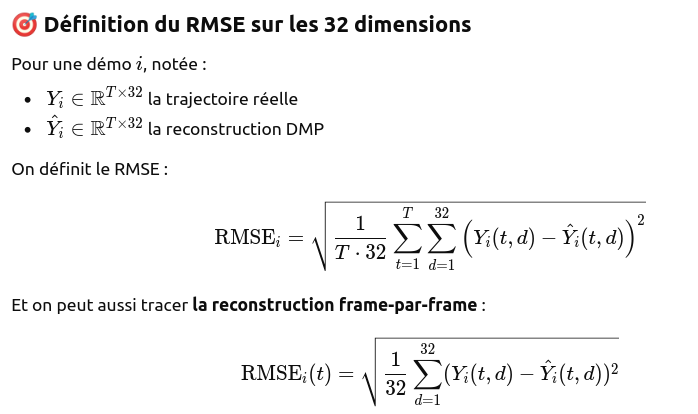

In [25]:
#Function evaluation DMP reconstruction

def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)

    return rmse_all, rmse_per_frame

In [26]:
def analyse_label(label, n=100, target_len=50, n_basis=20):
    """
    Construit le dataset pour `label`, entraîne un DMP multi-démos,
    calcule les RMSE et trace RMSE par frame (toutes les vidéos + moyenne).

    Retourne :
      - rmse_all        : (N,) RMSE globale par démo
      - rmse_per_frame  : (N, T) RMSE à chaque frame
      - dmp             : le DMPVector entraîné
      - X               : (N, T, D) les trajectoires utilisées
      - vids            : liste des chemins de vidéos
    """

    # 1) Dataset
    X, vids = build_gesture_dataset(label, n=n, target_len=target_len)

    # 2) Train DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 3) Evaluate reconstruction
    rmse_all, rmse_per_frame = evaluate_dmp_reconstruction(dmp, X)

    # 4) Stats globales
    # print(f"\n=== Résultats pour le label: {label} ===")
    # print("RMSE par démo :", rmse_all)
    # print("RMSE moyenne :", rmse_all.mean())
    # print("RMSE max :", rmse_all.max())
    # print("Number of videos ", rmse_all.shape[0])
    # 5) Plot RMSE per frame
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame.shape[0]):
        plt.plot(rmse_per_frame[i], alpha=0.25)

    # Courbe moyenne
    plt.plot(rmse_per_frame.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE par frame pour le geste '{label}'")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all, rmse_per_frame, dmp, X, vids

Utiliser fonction analyse_label("label") pour visualiser les résultats obtenus pour un label.

I0000 00:00:1765008050.820412   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 18 vidéos disponibles pour 'point', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765008050.821443   33009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765008050.889858   33003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008050.916656   32993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 41.52it/s]
I0000 00:00:1765008051.865460   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008051.866359   33060 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765008051.909424   33044 inference_feedback_manager.cc:114] Feedba

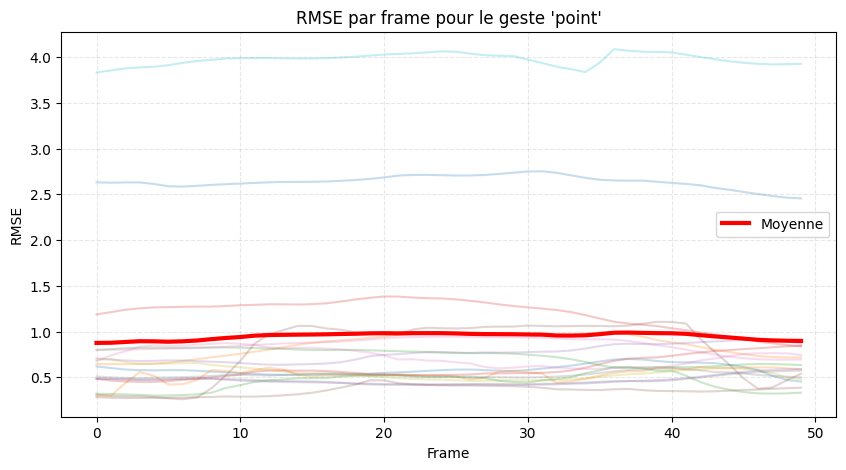

(array([2.63904572, 0.857317  , 0.74149108, 1.21031736, 0.7692229 ,
        0.86930955, 0.85724366, 0.46683778, 0.55432327, 3.97745385,
        0.58671748, 0.53412417, 0.45528445, 0.60891913, 0.46755467,
        0.35766779, 0.72944643, 0.52592615]),
 array([[2.6314842 , 2.62786285, 2.6309894 , 2.63054804, 2.61427557,
         2.58865871, 2.58532445, 2.59376545, 2.60389863, 2.61143842,
         2.61822257, 2.62578573, 2.63233017, 2.63563169, 2.63619909,
         2.63742956, 2.64083436, 2.64843655, 2.65724737, 2.66914379,
         2.68574217, 2.70578545, 2.71302047, 2.71329997, 2.70989356,
         2.70617417, 2.70633509, 2.71287956, 2.72342297, 2.73714717,
         2.75032059, 2.7526994 , 2.73605003, 2.70829397, 2.68075892,
         2.6602513 , 2.65202384, 2.64985153, 2.65012551, 2.6378343 ,
         2.62555897, 2.61445374, 2.59941791, 2.57067069, 2.55136834,
         2.5266926 , 2.50378349, 2.48223429, 2.46418364, 2.45656348],
        [0.64292774, 0.64268582, 0.64280487, 0.64411418, 0.

In [27]:
analyse_label("point")


# Analyse de tous les labels du dataset DESRes en même temps

I0000 00:00:1765008074.889233   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 200 demandées.
👉 Retour de TOUTES les vidéos disponibles.


I0000 00:00:1765008074.890006   33951 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/313 [00:00<?, ?it/s]W0000 00:00:1765008074.938150   33936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008074.970038   33944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 313/313 [00:07<00:00, 42.83it/s]


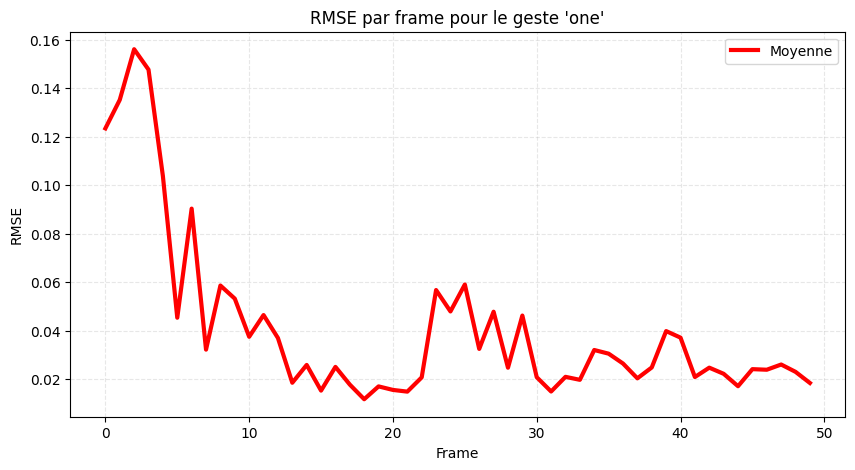

I0000 00:00:1765008082.324260   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008082.325556   34009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.053734]), array([[0.12343927, 0.13520004, 0.15607213, 0.1476706 , 0.10379593,
        0.04540525, 0.09036812, 0.03225766, 0.0586699 , 0.0532688 ,
        0.03755554, 0.04651172, 0.03704803, 0.01860406, 0.02594769,
        0.01536678, 0.02513994, 0.0178442 , 0.01181322, 0.01709697,
        0.01564237, 0.01494178, 0.02081881, 0.05681569, 0.04799735,
        0.05909893, 0.03254319, 0.04788219, 0.02479488, 0.04630279,
        0.02088807, 0.01499686, 0.02103801, 0.01980586, 0.03209877,
        0.0305865 , 0.02652601, 0.02042604, 0.02490605, 0.03989518,
        0.03719504, 0.02095763, 0.02482002, 0.02228897, 0.01717477,
        0.02420813, 0.02396886, 0.02611588, 0.02309006, 0.01850355]]), <__main__.DMPVector object at 0x725fcd079390>, array([[[ 0.58556992,  0.10170705,  0.55713273, ...,  1.72502818,
         -1.27301508, -1.47203059],
        [ 0.56458106,  0.07760553,  0.54549224, ...,  1.837     ,
         -0.63885949, -1.02886712],
        [ 0.56822375,  0.13202368,  0.55019806

  0%|          | 0/88 [00:00<?, ?it/s]W0000 00:00:1765008082.373637   33991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008082.403396   34003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 88/88 [00:02<00:00, 42.97it/s]


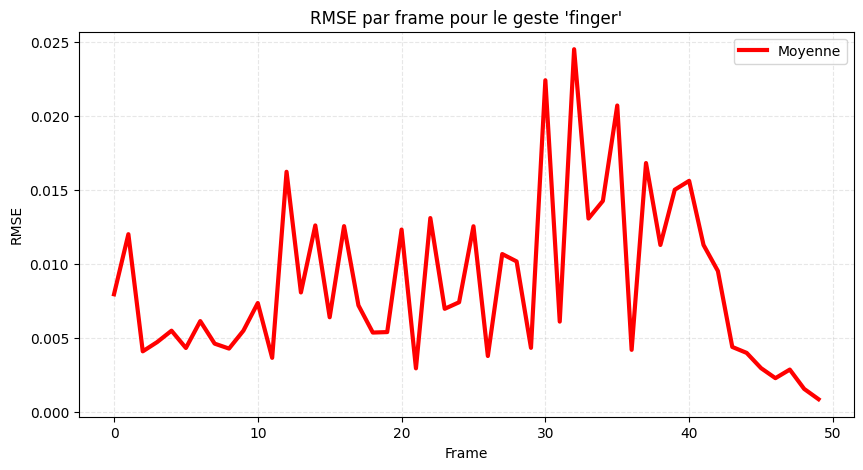

(array([0.01023025]), array([[0.00795632, 0.01201606, 0.00410219, 0.00472696, 0.00549645,
        0.00432887, 0.00614506, 0.00462224, 0.00428937, 0.00549871,
        0.00736669, 0.00366442, 0.01623215, 0.00808164, 0.01260802,
        0.00640502, 0.01256024, 0.00720859, 0.00537137, 0.0054038 ,
        0.01232869, 0.00295475, 0.01310549, 0.00697574, 0.00741801,
        0.01255225, 0.00378822, 0.01067551, 0.01017669, 0.00433902,
        0.02241533, 0.0061113 , 0.02451115, 0.01307329, 0.01426412,
        0.02070901, 0.00420361, 0.01682225, 0.01128982, 0.01502027,
        0.01562017, 0.01129028, 0.00952802, 0.00439954, 0.0039978 ,
        0.00296883, 0.00229069, 0.00287021, 0.00156515, 0.00086836]]), <__main__.DMPVector object at 0x725fcd79c7c0>, array([[[ 0.60309848,  0.04791907,  0.58917838, ...,  0.26009976,
         -0.64574861, -0.57713389],
        [ 0.61071262,  0.0308068 ,  0.59142708, ...,  0.32275937,
         -0.61658843, -0.5428661 ],
        [ 0.61095892,  0.02947493,  0.591729

I0000 00:00:1765008084.472765   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/33 [00:00<?, ?it/s]I0000 00:00:1765008084.473442   34091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765008084.523090   34073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008084.549341   34083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 33/33 [00:00<00:00, 38.62it/s]
I0000 00:00:1765008085.350925   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008085.352184   34143 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

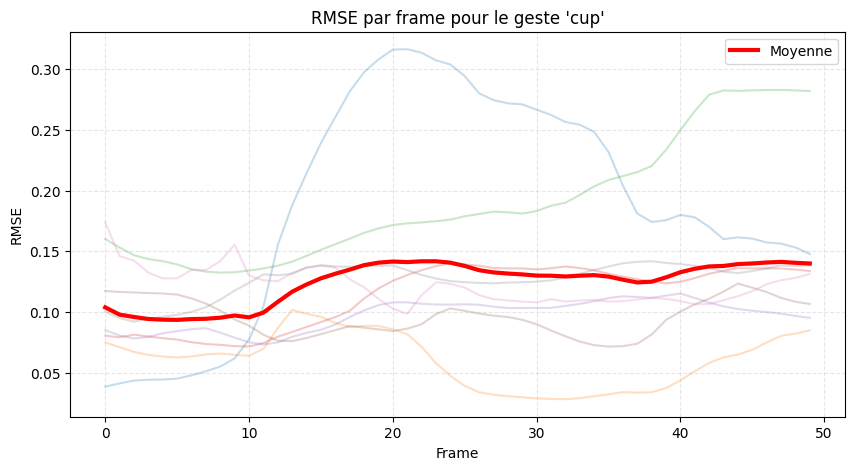

I0000 00:00:1765008091.176178   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.20929654, 0.06470949, 0.19664896, 0.11662506, 0.09824707,
       0.09728631, 0.1227828 , 0.12760456]), array([[0.03877743, 0.04133838, 0.04369849, 0.04438345, 0.0445559 ,
        0.04531206, 0.04801955, 0.05132068, 0.05520744, 0.06197755,
        0.07745648, 0.10454171, 0.1553711 , 0.18784983, 0.21422444,
        0.23902288, 0.26044555, 0.28143336, 0.29734204, 0.30785338,
        0.31591064, 0.31621665, 0.31335043, 0.30707596, 0.30366697,
        0.29413714, 0.27991971, 0.27443992, 0.27170376, 0.27085007,
        0.26646938, 0.26221997, 0.25636257, 0.25413653, 0.2482638 ,
        0.23170259, 0.20401172, 0.18104652, 0.17414266, 0.1755948 ,
        0.17993281, 0.1779573 , 0.17002099, 0.16001453, 0.16145649,
        0.16047662, 0.15727511, 0.15633823, 0.15322926, 0.1477946 ],
       [0.07500591, 0.07122135, 0.06722256, 0.06480207, 0.06340803,
        0.06269188, 0.0635388 , 0.06523204, 0.06592031, 0.06482514,
        0.0640768 , 0.06986214, 0.0868499 , 0.10175427, 0.0986497 ,
  

I0000 00:00:1765008091.176958   34500 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765008091.218606   34492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008091.245074   34486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 52/52 [00:01<00:00, 44.89it/s]


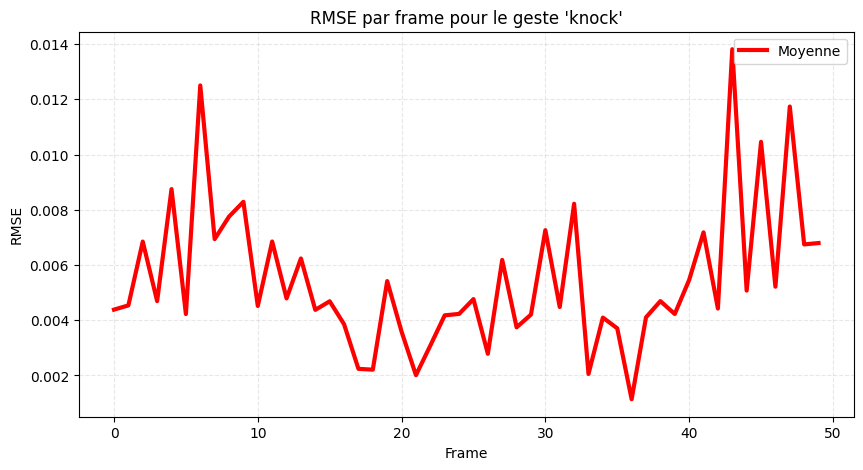

(array([0.00606558]), array([[0.00438371, 0.00453732, 0.00684908, 0.00469297, 0.00874811,
        0.00422335, 0.01250232, 0.00693716, 0.0077532 , 0.00828858,
        0.00451728, 0.00685167, 0.00479027, 0.00623631, 0.00437495,
        0.00468643, 0.00385638, 0.00223955, 0.00221007, 0.00541801,
        0.00358717, 0.00201046, 0.00308361, 0.00417694, 0.00422946,
        0.00476537, 0.00278494, 0.00618305, 0.00374292, 0.00420471,
        0.00726083, 0.00447937, 0.00821727, 0.00205529, 0.00409659,
        0.00370677, 0.00113988, 0.00410527, 0.00469229, 0.00422639,
        0.00545825, 0.00718262, 0.00442428, 0.01381364, 0.00507327,
        0.01045927, 0.00521463, 0.01173828, 0.00674603, 0.00679518]]), <__main__.DMPVector object at 0x725fcd7527d0>, array([[[ 0.52903524,  0.0777966 ,  0.5133428 , ...,  0.75908287,
         -0.76894629, -0.84263668],
        [ 0.5533336 ,  0.08362822,  0.53339921, ...,  0.76377474,
         -0.75152551, -0.83767919],
        [ 0.55940285,  0.09192545,  0.536247

I0000 00:00:1765008092.442578   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008092.443583   34551 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765008092.499932   34537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008092.524654   34536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 41.97it/s]
I0000 00:00:1765008093.185704   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008093.186839   34602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

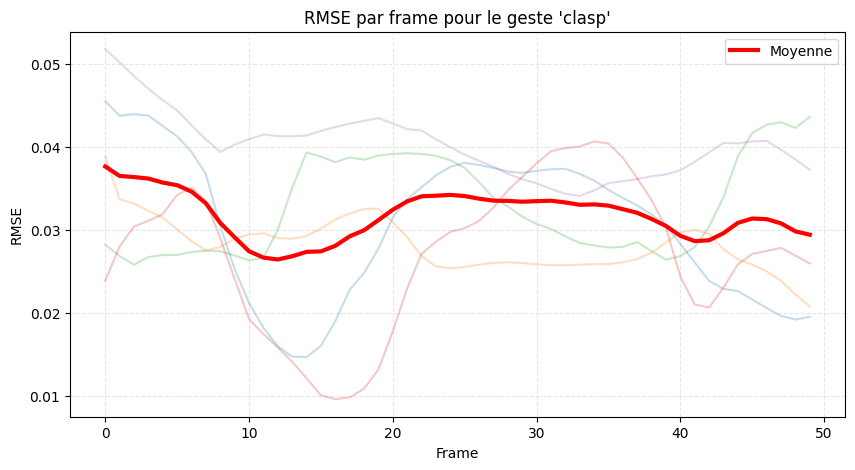

I0000 00:00:1765008097.109936   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.03170299, 0.0283689 , 0.03337394, 0.02846298, 0.04044352]), array([[0.04548247, 0.04373378, 0.04391854, 0.04375978, 0.04249878,
        0.04125628, 0.03939645, 0.03671279, 0.03044361, 0.02532218,
        0.02121029, 0.01824378, 0.01601564, 0.01476913, 0.01472323,
        0.01608179, 0.0190508 , 0.02281144, 0.02483956, 0.02775719,
        0.03151253, 0.03372708, 0.03513119, 0.03656822, 0.03759107,
        0.03808114, 0.03782253, 0.03745604, 0.03703617, 0.03686135,
        0.03711414, 0.03730074, 0.03735108, 0.03674343, 0.03594151,
        0.03482749, 0.03383623, 0.03295379, 0.03185349, 0.03050408,
        0.02831821, 0.02610234, 0.02388929, 0.02291676, 0.02265854,
        0.0216297 , 0.02062429, 0.0196637 , 0.01923256, 0.0195719 ],
       [0.0388059 , 0.03370503, 0.03317025, 0.03230298, 0.03150132,
        0.03006804, 0.02865411, 0.02751712, 0.02796666, 0.02895858,
        0.02946378, 0.02957541, 0.02902769, 0.02895645, 0.02926886,
        0.03018821, 0.03126289, 0.03199181, 0

I0000 00:00:1765008097.110805   34809 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1765008097.155443   34791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008097.186327   34798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 31/31 [00:00<00:00, 39.51it/s]
I0000 00:00:1765008097.920633   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008097.921986   34860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/177 [00:00<?, ?it/s]W0000 00:00:1765008097.970742   34847 inference_feedback_manager.cc:114] Feedb

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2157_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008264.086443   39563 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/47 [00:00<?, ?it/s]W0000 00:00:1765008264.150819   39548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008264.177314   39557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 47/47 [00:01<00:00, 46.73it/s]
I0000 00:00:1765008265.118165   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/139 [00:00<?, ?it/s]I0000 00:00:1765008265.120692   39615 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765008265.176829   39597 inference_feedback_manager.cc:114] Feedb

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008284.365407   40185 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/122 [00:00<?, ?it/s]W0000 00:00:1765008284.409593   40176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008284.436061   40175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 122/122 [00:02<00:00, 42.75it/s]
I0000 00:00:1765008287.237502   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008287.238611   40236 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/36 [00:00<?, ?it/s]W0000 00:00:1765008287.286697   40220 inference_feedback_manager.cc:114] Fee

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2243_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008343.776700   41919 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/27 [00:00<?, ?it/s]W0000 00:00:1765008343.826168   41904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008343.851560   41908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 27/27 [00:00<00:00, 37.71it/s]
I0000 00:00:1765008344.513349   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008344.514811   41974 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765008344.570498   41958 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2177_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/85 [00:00<?, ?it/s]W0000 00:00:1765008356.601225   42262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008356.626999   42274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 85/85 [00:02<00:00, 41.81it/s]
I0000 00:00:1765008358.618957   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008358.619951   42331 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/80 [00:00<?, ?it/s]W0000 00:00:1765008358.663666   42315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008358.687303   42322 inference_feedback_ma

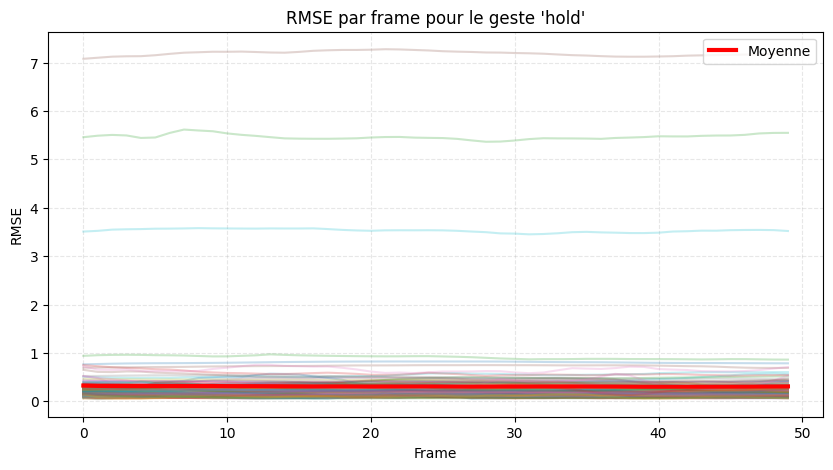

I0000 00:00:1765008410.004681   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008410.005608   43809 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.13699926, 0.20708756, 0.21187499, 0.2433692 , 0.18184291,
       0.41972734, 0.28691107, 0.50415277, 0.19628156, 0.14305221,
       0.33584284, 0.19785044, 0.27465577, 0.28411776, 0.40755938,
       0.16825015, 0.14672391, 0.19331209, 0.17884503, 0.22434532,
       0.34551707, 0.15994334, 0.15436036, 0.0869395 , 0.13534321,
       0.1448371 , 0.15489365, 0.09725917, 0.23103564, 0.54453967,
       0.80404079, 0.11529008, 0.33992243, 0.08073579, 0.1313676 ,
       0.11830081, 0.34983695, 0.17882722, 0.13440325, 0.18518019,
       0.30838608, 0.11008067, 0.91276087, 0.08186427, 0.20862105,
       0.11213092, 0.32691072, 0.22880827, 0.23642622, 0.17541219,
       0.24626893, 0.21167993, 0.12278565, 0.12475548, 0.14506314,
       0.16290773, 0.20732492, 0.15012535, 0.12714043, 0.33393376,
       0.34027657, 0.10222653, 0.17710655, 0.14883157, 0.28629691,
       0.17340329, 0.15683494, 0.21676762, 0.20836189, 0.19182248,
       0.22227428, 0.12679327, 0.41448519, 0.3225558 , 0.1852

  0%|          | 0/19 [00:00<?, ?it/s]W0000 00:00:1765008410.045716   43792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008410.071548   43800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 19/19 [00:00<00:00, 38.65it/s]


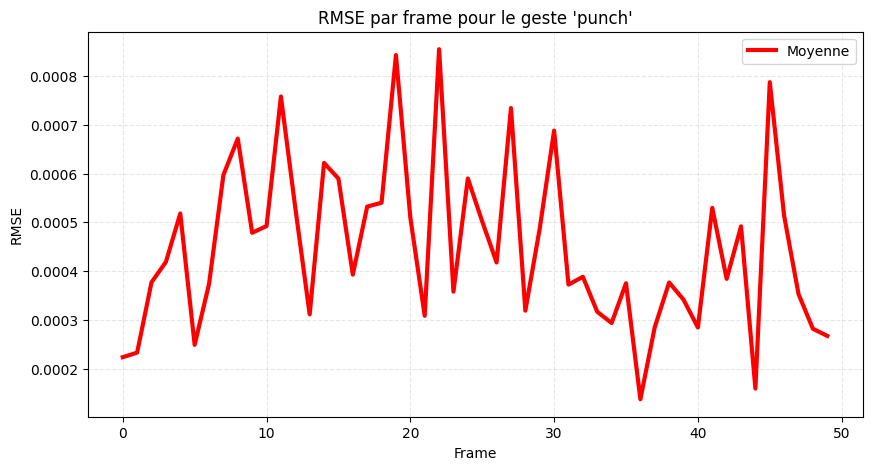

I0000 00:00:1765008410.596128   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008410.597138   43860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00048057]), array([[0.0002232 , 0.00023261, 0.00037686, 0.00041868, 0.00051812,
        0.00024856, 0.00037335, 0.00059705, 0.00067191, 0.00047861,
        0.0004923 , 0.00075825, 0.00052985, 0.00031107, 0.00062193,
        0.00058972, 0.00039271, 0.00053226, 0.00054016, 0.00084336,
        0.00050993, 0.00030825, 0.0008553 , 0.00035779, 0.00059011,
        0.00050185, 0.00041759, 0.00073453, 0.00031869, 0.0004874 ,
        0.00068822, 0.00037216, 0.00038827, 0.00031635, 0.00029342,
        0.00037503, 0.00013695, 0.0002848 , 0.00037652, 0.00034143,
        0.00028412, 0.00052966, 0.00038399, 0.00049174, 0.00015882,
        0.00078772, 0.00051291, 0.00035254, 0.00028152, 0.00026691]]), <__main__.DMPVector object at 0x725fcd084eb0>, array([[[ 0.54314768, -0.16826506,  0.52315786, ...,  0.15642332,
         -0.85810385, -0.30581226],
        [ 0.54427163, -0.16494725,  0.52162238, ...,  0.15793831,
         -0.87591055, -0.30429727],
        [ 0.54539557, -0.16162945,  0.520086

  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765008410.640860   43843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008410.670859   43853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 39.58it/s]
I0000 00:00:1765008411.680599   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008411.681540   43911 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765008411.735547   43897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008411.760385   43903 inference_feedback_ma

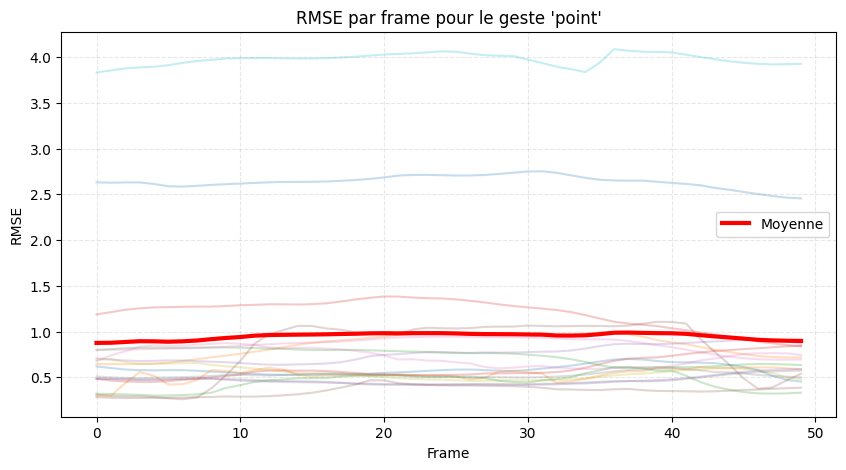

I0000 00:00:1765008434.816984   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([2.63904572, 0.857317  , 0.74149108, 1.21031736, 0.7692229 ,
       0.86930955, 0.85724366, 0.46683778, 0.55432327, 3.97745385,
       0.58671748, 0.53412417, 0.45528445, 0.60891913, 0.46755467,
       0.35766779, 0.72944643, 0.52592615]), array([[2.6314842 , 2.62786285, 2.6309894 , 2.63054804, 2.61427557,
        2.58865871, 2.58532445, 2.59376545, 2.60389863, 2.61143842,
        2.61822257, 2.62578573, 2.63233017, 2.63563169, 2.63619909,
        2.63742956, 2.64083436, 2.64843655, 2.65724737, 2.66914379,
        2.68574217, 2.70578545, 2.71302047, 2.71329997, 2.70989356,
        2.70617417, 2.70633509, 2.71287956, 2.72342297, 2.73714717,
        2.75032059, 2.7526994 , 2.73605003, 2.70829397, 2.68075892,
        2.6602513 , 2.65202384, 2.64985153, 2.65012551, 2.6378343 ,
        2.62555897, 2.61445374, 2.59941791, 2.57067069, 2.55136834,
        2.5266926 , 2.50378349, 2.48223429, 2.46418364, 2.45656348],
       [0.64292774, 0.64268582, 0.64280487, 0.64411418, 0.64936519,
    

I0000 00:00:1765008434.817906   44823 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765008434.860530   44806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008434.889983   44819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 43/43 [00:01<00:00, 42.61it/s]


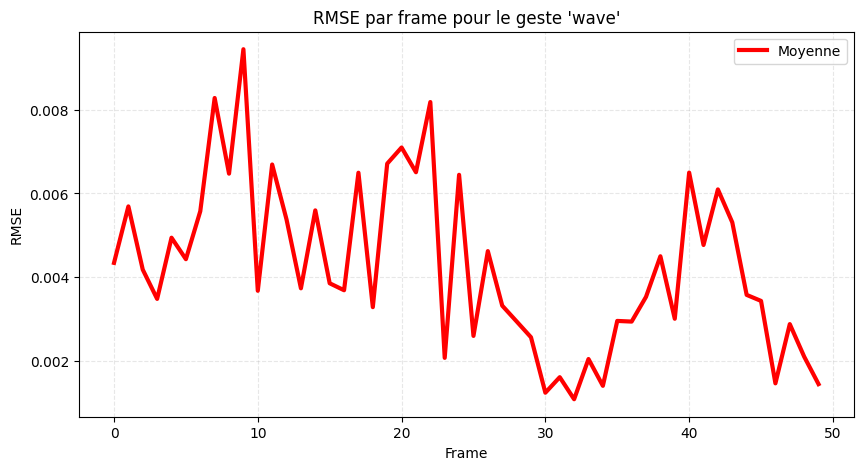

I0000 00:00:1765008435.927322   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00472562]), array([[0.00433843, 0.00569121, 0.00417788, 0.00347689, 0.00494155,
        0.00442764, 0.00557507, 0.00828563, 0.00647493, 0.00945315,
        0.00367124, 0.00669354, 0.00537608, 0.00373049, 0.00559555,
        0.0038509 , 0.00368389, 0.00649679, 0.00327957, 0.00671416,
        0.00710104, 0.0065088 , 0.00818863, 0.00206591, 0.00644704,
        0.00259132, 0.00462032, 0.00331537, 0.00293822, 0.00255844,
        0.00123147, 0.00160307, 0.00107556, 0.00203759, 0.00139598,
        0.00294967, 0.00293387, 0.00352541, 0.00449766, 0.00300182,
        0.00649999, 0.00476705, 0.00609772, 0.00530881, 0.00357296,
        0.00342857, 0.00145585, 0.00287366, 0.00209517, 0.00143665]]), <__main__.DMPVector object at 0x725fb45d0a00>, array([[[ 0.47229006, -0.01565621,  0.44271983, ...,  0.87481027,
         -1.23692052, -0.60965354],
        [ 0.49775438, -0.05695699,  0.46818414, ...,  0.88317731,
         -1.2476486 , -0.60128651],
        [ 0.50268204, -0.06723573,  0.474405

I0000 00:00:1765008435.928477   44875 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/77 [00:00<?, ?it/s]W0000 00:00:1765008435.975566   44859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008436.003977   44869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 77/77 [00:01<00:00, 41.95it/s]
I0000 00:00:1765008437.785279   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008437.786198   44929 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765008437.841131   44915 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1805_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008510.893919   47535 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765008510.938163   47517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008510.966629   47529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:00<00:00, 42.71it/s]
I0000 00:00:1765008511.896225   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008511.897036   47587 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]W0000 00:00:1765008511.942368   47571 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1923_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008546.571865   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008546.572842   48408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/54 [00:00<?, ?it/s]W0000 00:00:1765008546.616873   48395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008546.645265   48397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 54/54 [00:01<00:00, 47.14it/s]
I0000 00:00:1765008547.745621   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008547.746702   48459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/2231_Lecturer3_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765008563.400081   48719 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765008563.459688   48704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008563.486833   48711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 38.67it/s]
I0000 00:00:1765008564.195962   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008564.197173   48770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/73 [00:00<?, ?it/s]W0000 00:00:1765008564.253215   48755 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1925_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/23 [00:00<?, ?it/s]W0000 00:00:1765008575.653224   49163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008575.678190   49174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 23/23 [00:00<00:00, 38.24it/s]
I0000 00:00:1765008576.216612   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008576.217404   49232 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/56 [00:00<?, ?it/s]W0000 00:00:1765008576.272478   49217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008576.300983   49225 inference_feedback_ma

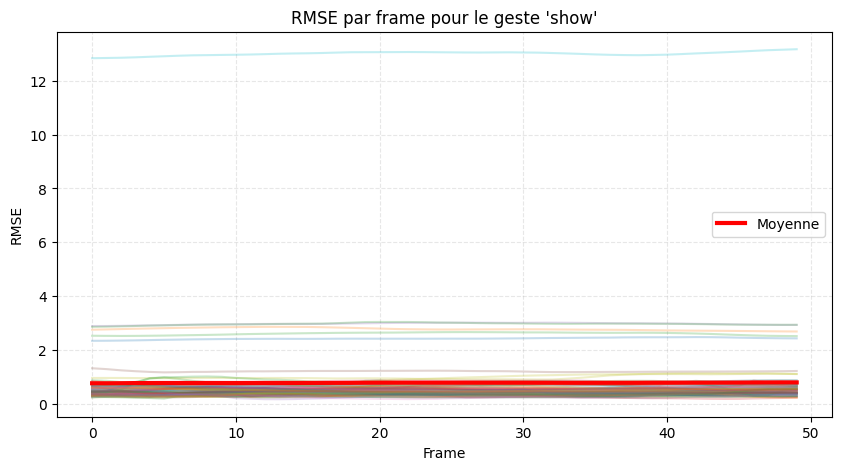

I0000 00:00:1765008587.319500   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008587.320392   49578 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([ 0.36364187,  0.36901567,  0.74552136,  0.55429778,  0.32387707,
        0.47348412,  0.66044647,  0.67284285,  0.99023465,  0.73886462,
        0.60552423,  2.77194141,  2.6016891 ,  0.59315593,  0.36265555,
        0.41984251,  0.58569353,  0.75261835,  0.43405485,  0.32474632,
        0.53868947,  0.45119823,  0.26982032,  0.33512115,  2.96800579,
        0.55317482,  0.5241669 ,  0.48790623,  0.26369781,  0.50312776,
        0.31836513,  0.42029579,  0.70568726,  0.44839218,  0.53798677,
        1.20405162,  0.52978828,  0.64655344,  0.92634219,  0.50662506,
        0.40489708,  0.54474077,  2.9623616 ,  0.2864429 ,  0.40103652,
        0.33242221,  0.4779824 ,  0.35334624,  0.62896542,  0.67009276,
        2.42022779,  0.44459895,  0.79642625,  0.68210414,  0.52064362,
        0.48343438,  0.56252664,  0.51011069,  0.43068772,  0.53436868,
        0.33255326,  0.62089898,  0.41649281,  0.43382483,  0.54610429,
        0.54192009,  0.32316949,  0.51835975,  0.50172015,  0.4

  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765008587.364034   49567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008587.389898   49572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 32/32 [00:00<00:00, 41.28it/s]
I0000 00:00:1765008588.122441   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008588.123963   49629 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/25 [00:00<?, ?it/s]W0000 00:00:1765008588.170191   49612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008588.196859   49617 inference_feedback_ma

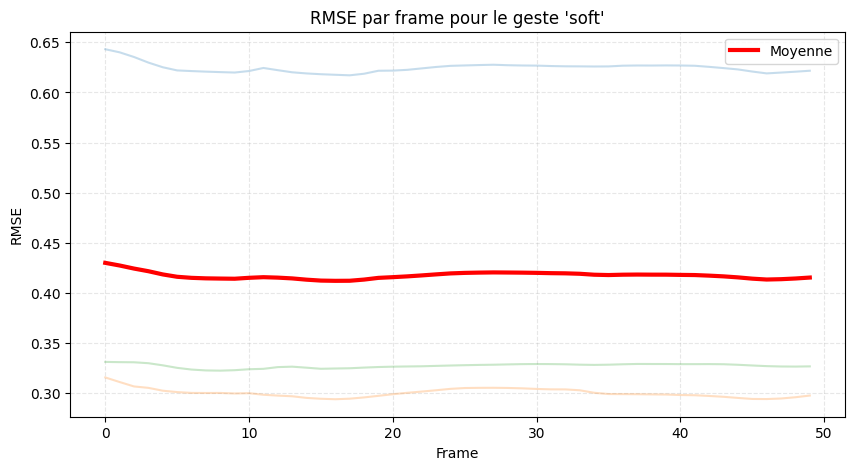

(array([0.62453716, 0.30039744, 0.32736878]), array([[0.64309021, 0.63999163, 0.63533448, 0.62976439, 0.62511703,
        0.62195562, 0.62130801, 0.62073687, 0.62026887, 0.61984183,
        0.62135526, 0.62440137, 0.62219206, 0.62008518, 0.6189493 ,
        0.61816549, 0.6176006 , 0.61707713, 0.6186509 , 0.62162578,
        0.62176903, 0.62252695, 0.62395502, 0.62537794, 0.62650282,
        0.62691352, 0.62730619, 0.62761692, 0.62714284, 0.62686372,
        0.62674473, 0.62632392, 0.62605518, 0.62599342, 0.62586504,
        0.6259445 , 0.62666892, 0.62686816, 0.62682553, 0.62693917,
        0.62685521, 0.6265981 , 0.62550932, 0.62428258, 0.62295442,
        0.62083189, 0.6189826 , 0.61981521, 0.62068157, 0.62163442],
       [0.31580639, 0.31123461, 0.30682588, 0.30542504, 0.30258519,
        0.30121008, 0.3003827 , 0.30030329, 0.3003506 , 0.29982453,
        0.30011536, 0.29854618, 0.29769523, 0.29704152, 0.29540736,
        0.29453858, 0.29409177, 0.29461889, 0.29589659, 0.2974754 ,
 

I0000 00:00:1765008589.366222   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/49 [00:00<?, ?it/s]I0000 00:00:1765008589.367088   49731 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765008589.412453   49716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008589.438918   49723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 39.67it/s]
I0000 00:00:1765008590.624498   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008590.626009   49783 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

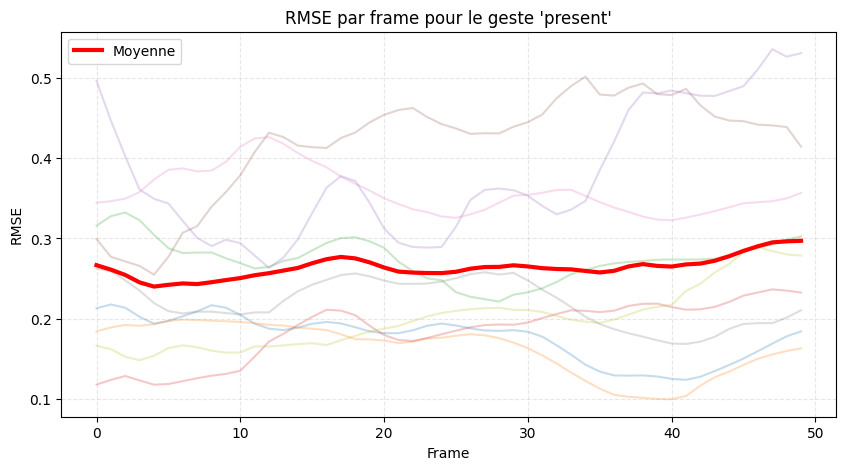

I0000 00:00:1765008601.350078   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.17919143, 0.16620244, 0.27555575, 0.18887069, 0.38769686,
       0.42294226, 0.35931697, 0.2221373 , 0.20414825]), array([[0.21313561, 0.21788877, 0.21378902, 0.20253455, 0.19397348,
        0.19745332, 0.20323173, 0.20930413, 0.21701098, 0.21386836,
        0.20506689, 0.19406158, 0.18775871, 0.18604856, 0.1890115 ,
        0.19398573, 0.19609769, 0.19430014, 0.18956137, 0.18438445,
        0.18212519, 0.1821902 , 0.18576037, 0.19139345, 0.19415421,
        0.19178335, 0.18813764, 0.1855615 , 0.18506878, 0.18588109,
        0.18396024, 0.17788147, 0.16717109, 0.1555237 , 0.14304277,
        0.13443843, 0.12959772, 0.12936118, 0.12962531, 0.12822949,
        0.12534807, 0.12415023, 0.12795589, 0.1350735 , 0.14257557,
        0.15062899, 0.15982189, 0.16915122, 0.17829869, 0.18432732],
       [0.18462491, 0.18930964, 0.19243982, 0.19139533, 0.19342948,
        0.19746546, 0.19907961, 0.19844211, 0.19762754, 0.19699636,
        0.19618083, 0.19457684, 0.19252975, 0.19165521, 0.

I0000 00:00:1765008601.351234   50192 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765008601.399309   50174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765008601.427061   50183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 39.18it/s]
I0000 00:00:1765008602.622077   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765008602.623242   50243 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765008602.666210   50227 inference_feedback_manager.cc:114] Feedba

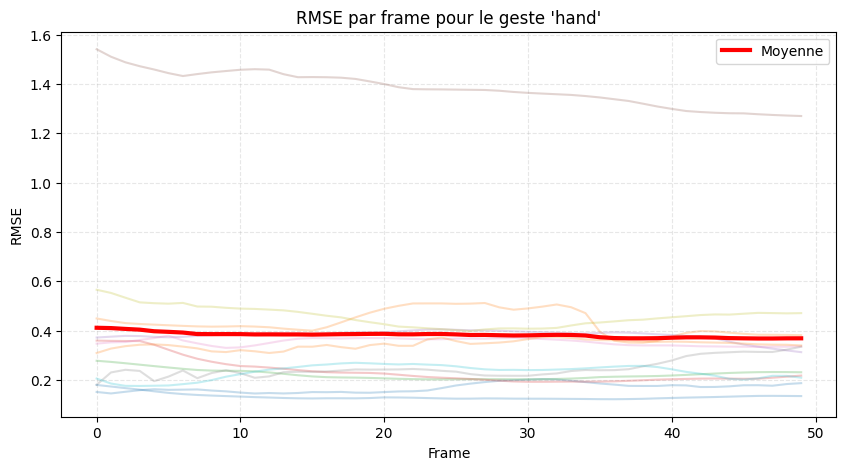

(array([0.16966917, 0.43608801, 0.22371304, 0.23972919, 0.38180014,
       1.38335673, 0.3541814 , 0.24885599, 0.459782  , 0.23371367,
       0.1329772 , 0.34450397]), array([[0.15114247, 0.14516244, 0.15193127, 0.15848292, 0.16225699,
        0.15974766, 0.16050069, 0.16141134, 0.15691511, 0.15361667,
        0.14866671, 0.14495075, 0.14689088, 0.1451681 , 0.1469709 ,
        0.15075583, 0.15026054, 0.15134007, 0.14838437, 0.14797848,
        0.15072543, 0.1532683 , 0.15396468, 0.15706669, 0.16684467,
        0.17750407, 0.18490337, 0.19128075, 0.19650829, 0.1988259 ,
        0.2009241 , 0.20303683, 0.20176744, 0.19663435, 0.19110043,
        0.18550175, 0.18099972, 0.1758322 , 0.17548211, 0.17551818,
        0.17857899, 0.17781724, 0.17122706, 0.17148011, 0.17397114,
        0.1783483 , 0.17858465, 0.17642743, 0.18328549, 0.18692998],
       [0.4491966 , 0.4389175 , 0.43040925, 0.42670398, 0.42410286,
        0.42158876, 0.41912765, 0.41705564, 0.41598314, 0.4166353 ,
        0.41794

In [ ]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label(i, n=200, target_len=50, n_basis=20)) 
    
analyse_full_DESRes()

### Analyse label from Jester Dataset

I0000 00:00:1765010703.126937   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010703.128187   53067 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010703.171232   53051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010703.194614   53049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.96it/s]
I0000 00:00:1765010704.052519   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010704.053752   53118 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/3406.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765010761.072754   56334 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010761.131421   56317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010761.166171   56328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.92it/s]
I0000 00:00:1765010761.913438   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010761.914736   56385 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010761.955109   56368 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/68938.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010763.857758   56472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010763.885239   56483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.03it/s]
I0000 00:00:1765010764.683450   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010764.684424   56539 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010764.731537   56522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010764.761598   56534 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/53698.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765010769.202510   56794 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010769.260495   56780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010769.287656   56785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.87it/s]
I0000 00:00:1765010770.137152   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010770.138481   56845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010770.187969   56827 inference_feedback_manager.cc:114] Feedba

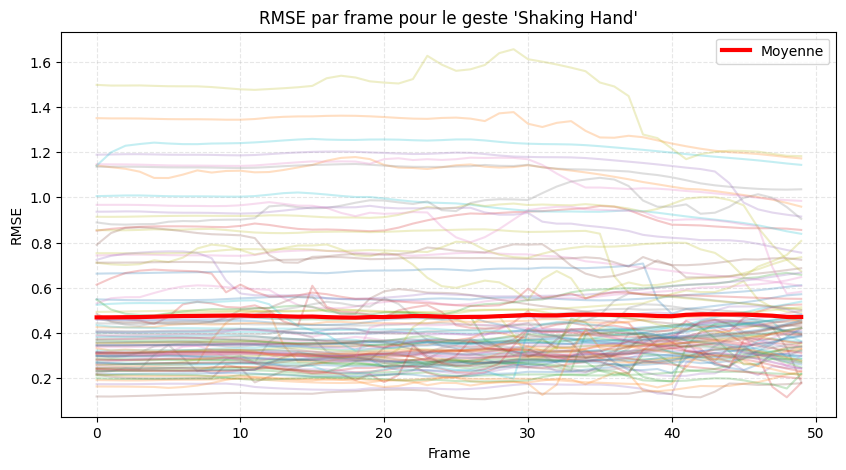

(array([0.55728227, 1.10148461, 0.26057737, 0.32369409, 0.29965082,
        0.49623703, 0.39396195, 0.39121526, 0.51541846, 0.41123483,
        0.32684388, 0.30557865, 0.41632747, 0.88927896, 0.37363524,
        0.32889381, 0.41323079, 0.45339261, 0.68934878, 0.31856878,
        0.28449513, 0.37680613, 0.30157514, 0.47235993, 0.39649642,
        0.29328083, 0.35305535, 1.11668901, 0.48946077, 0.38074324,
        0.43052657, 0.2823177 , 0.36936729, 0.25959732, 0.34469002,
        0.32279428, 0.72292136, 0.45615193, 0.33889793, 0.96301346,
        0.64797562, 0.45042513, 0.36907161, 0.36982103, 0.24453523,
        0.13696873, 0.30488861, 0.33226959, 0.77869293, 0.42205713,
        0.28431941, 1.31068665, 0.26316052, 0.31503525, 0.1900758 ,
        0.75003735, 1.11071425, 0.2849963 , 0.92945087, 0.38879802,
        0.28200709, 0.18603367, 0.26708367, 0.27350368, 1.15636386,
        0.72150173, 0.5680867 , 0.36698506, 0.3684075 , 1.22445461,
        0.26792768, 0.21278316, 0.22602686, 0.32

In [35]:
analyse_label("Shaking Hand")

I0000 00:00:1765010880.982387   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010880.983361   58294 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010881.029496   58278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010881.058983   58291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.67it/s]
I0000 00:00:1765010881.920528   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010881.921980   58345 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/12438.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765010891.998076   58907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010892.082535   58890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010892.112330   58900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.57it/s]
I0000 00:00:1765010892.898914   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010892.900429   58958 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010892.957722   58942 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/4994.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010903.376669   59503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010903.402529   59515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.84it/s]
I0000 00:00:1765010904.172840   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765010904.174006   59572 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765010904.231323   59554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010904.260315   59562 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/143269.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765010909.694694   59881 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010909.784609   59864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010909.812933   59871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.46it/s]
I0000 00:00:1765010910.637312   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010910.638686   59932 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010910.707747   59915 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/21092.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010922.957069   60616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010922.984677   60622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.80it/s]
I0000 00:00:1765010923.804041   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010923.806261   60684 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010923.862503   60667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010923.889829   60676 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/140878.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765010934.124351   61252 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010934.183608   61240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765010934.213882   61245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.59it/s]
I0000 00:00:1765010935.088633   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765010935.090539   61304 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765010935.150648   61291 inference_feedback_manager.cc:114] Feedba

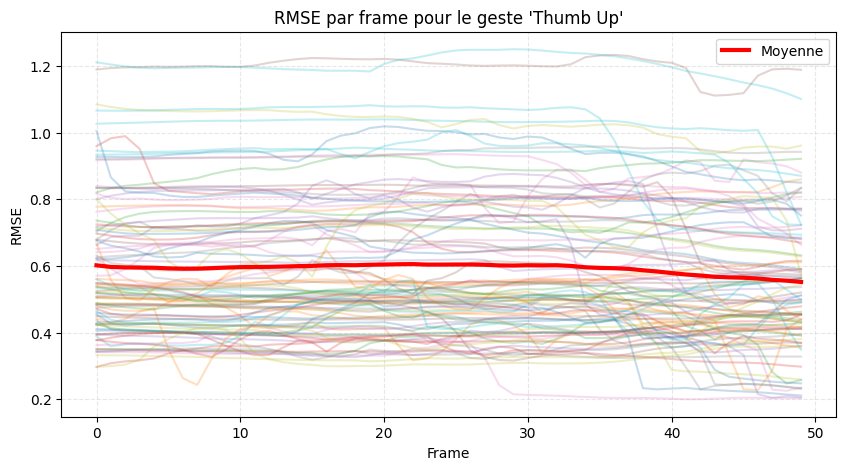

(array([0.94238981, 0.50896691, 0.5159493 , 0.66442014, 0.38374086,
        0.65477925, 0.55319439, 0.72214803, 0.44462379, 0.43494382,
        0.44722938, 0.42149059, 0.4791378 , 0.37080564, 0.53609828,
        0.52444078, 0.78797041, 0.34828064, 0.33292729, 1.01904945,
        0.67712331, 0.45544589, 0.70597868, 0.82380387, 0.82217482,
        1.19923785, 0.80458054, 0.72844527, 0.70073127, 0.50138058,
        0.68960015, 0.79158878, 0.75940223, 0.40580038, 0.72888612,
        0.54869206, 0.66786308, 0.3584375 , 1.02785491, 0.51750964,
        0.448829  , 0.52781729, 0.40915622, 0.33627836, 0.44385129,
        0.44298091, 0.89677139, 0.81882662, 0.51468894, 1.20181009,
        0.70053981, 0.48511064, 0.38752633, 0.38135631, 0.49559584,
        0.42315082, 0.78604976, 0.64110181, 0.41547739, 0.47322419,
        0.40298792, 0.55055254, 0.89548905, 0.54038155, 0.66263028,
        0.80148777, 0.35569631, 0.93866568, 0.72734087, 0.92686884,
        0.38278986, 0.42891424, 0.49511261, 0.38

In [37]:
analyse_label("Thumb Up")

I0000 00:00:1765011094.720910   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765011094.722022   63565 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765011094.782680   63550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765011094.806268   63547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.08it/s]
I0000 00:00:1765011095.583175   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765011095.583905   63616 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/45794.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765011138.623476   66047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765011138.653069   66058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.25it/s]
I0000 00:00:1765011139.506103   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765011139.508541   66112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765011139.555609   66100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765011139.580370   66104 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/95403.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765011171.431160   67905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765011171.481945   67895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765011171.507713   67893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.15it/s]
I0000 00:00:1765011172.364268   14880 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765011172.365314   67957 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765011172.410021   67941 inference_feedback_manager.cc:114] Feedba

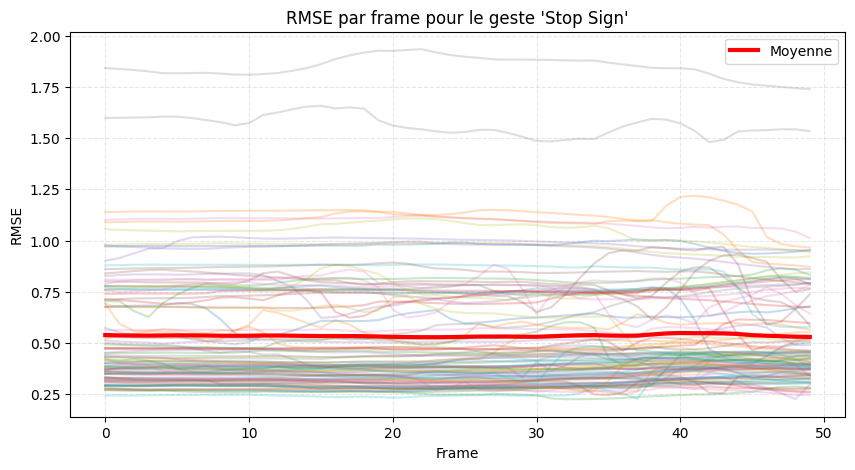

(array([0.36002949, 0.31218827, 0.3420073 , 0.48092518, 0.75771248,
        0.40478065, 0.33766301, 0.30112976, 0.37959501, 0.40440905,
        0.36033507, 0.38011526, 0.7711506 , 0.30238765, 0.35453323,
        0.79682618, 1.09269475, 0.61882778, 0.96848544, 0.85004424,
        0.71636366, 0.27722918, 0.25572173, 0.42154423, 0.51782762,
        0.52741118, 0.27016476, 1.84866617, 0.44495129, 0.41649717,
        0.28690388, 0.45190591, 0.27840368, 0.33712172, 0.98611123,
        0.79536997, 0.55995114, 0.43081897, 1.04635813, 0.76339517,
        0.34983675, 0.57497332, 0.49174503, 0.3182621 , 0.45260601,
        0.78931315, 0.76271164, 0.31673385, 0.39630847, 0.32751351,
        0.62965143, 0.50987145, 0.4480487 , 0.73853344, 0.95491516,
        0.74840032, 0.76716952, 1.56500112, 0.34387623, 0.39108758,
        0.28980414, 1.07750091, 0.39007845, 0.67950693, 0.38836502,
        0.47517633, 0.31878037, 0.43692573, 0.77673944, 0.30389466,
        0.9758358 , 1.13282682, 0.79669735, 0.37

In [38]:
analyse_label("Stop Sign")